In [1]:
import sqlite3
import re
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def calculer_nombre_offres_pour_metier(recherche_metier_nettoye):
    conn = sqlite3.connect('job_mining.db')
    cursor = conn.cursor()
    cursor.execute(f"SELECT COUNT(DISTINCT id) FROM OffresEmploi_Faits WHERE poste LIKE '%{recherche_metier_nettoye}%'")

    nombre_offres = cursor.fetchone()[0]
    conn.close()
    return nombre_offres

In [3]:
calculer_nombre_offres_pour_metier("data analyst")

81

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
conn = sqlite3.connect('job_mining.db')
cursor = conn.cursor()

#Récupérer les descriptions des postes correspondants à la recherche
query = f"SELECT * FROM OffresEmploi_Faits"
cursor.execute(query)
resultat = cursor.fetchall()   

resultat = pd.DataFrame(resultat, columns=['id',
    'poste',
    'typeContrat',
    'dateCreation',
    'dateActualisation',
    'description',
    'description_brute',
    'nombrePostes',
    'salaireLibelle',
    'lieuTravailId',
    'entrepriseId',
    'qualificationId',
    'origineOffreId'])

In [5]:
resultat['dateCreation'] = pd.to_datetime(resultat['dateCreation'], yearfirst=True)
resultat['Mois'] = resultat['dateCreation'].dt.month

In [6]:
#récupérer la liste des ponctuations
import string
ponctuations = list(string.punctuation)

ponctuations.insert(1,'°')
print(ponctuations)

#liste des chiffres
chiffres = list("0123456789")
print(chiffres)

#outil pour procéder à la lemmatisation - attention à charger le cas échéant
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()

#pour la tokénisation
from nltk.tokenize import word_tokenize

#liste des mots vides
from nltk.corpus import stopwords
mots_vides = stopwords.words("french")
print(mots_vides)

#********************************
#fonction pour nettoyage document (chaîne de caractères)
#le document revient sous la forme d'une liste de tokens
#********************************
def nettoyage_doc(doc_param):
    #passage en minuscule
    doc = doc_param.lower()
    #retrait des ponctuations
    doc = "".join([w for w in list(doc) if not w in ponctuations])
    #retirer les chiffres
    doc = "".join([w for w in list(doc) if not w in chiffres])
    #transformer le document en liste de termes par tokénisation
    doc = word_tokenize(doc)
    #lematisation de chaque terme
    doc = [lem.lemmatize(terme) for terme in doc]
    #retirer les stopwords
    doc = [w for w in doc if not w in mots_vides]
    #retirer les termes de moins de 3 caractères
    doc = [w for w in doc if len(w)>=3]
    #fin
    return doc

#************************************************************
#fonction pour nettoyage corpus
#attention, optionnellement les documents vides sont éliminés
#************************************************************
def nettoyage_corpus(corpus,vire_vide=True):
    #output
    output = [nettoyage_doc(doc) for doc in corpus if ((len(doc) > 0) or (vire_vide == False))]
    return output

['!', '°', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soye

In [7]:
resultat['description'] = nettoyage_corpus(resultat['description'])
resultat['description'] = resultat['description'].apply(lambda liste: ' '.join(liste))
resultat['poste'] = nettoyage_corpus(resultat['poste'])
resultat['poste'] = resultat['poste'].apply(lambda liste: ' '.join(liste))


In [8]:
resultat['Salchiffre'] = resultat['salaireLibelle'].astype(str)
resultat['Salchiffre'] = resultat['Salchiffre'].apply(lambda x: ' '.join(re.findall(r'\d+', str(x))))
len(resultat['Salchiffre'][0])
for index, row in resultat.iterrows():
    
    valeur = row['Salchiffre']

    if(len(valeur) == 20):
        resultat.loc[index, 'Salchiffre'] = str(resultat.loc[index, 'Salchiffre'])[0:2] + str(resultat.loc[index, 'Salchiffre'])[8:11]
        
    if(len(valeur) == 18):
        resultat.loc[index, 'Salchiffre'] = str(resultat.loc[index, 'Salchiffre'])[0:2] + str(resultat.loc[index, 'Salchiffre'])[7:10]
        
    if(len(valeur) == 14):
        resultat.loc[index, 'Salchiffre'] = str(resultat.loc[index, 'Salchiffre'])[0:2] + str(resultat.loc[index, 'Salchiffre'])[5:8]
        
    if((len(valeur) == 11) | (len(valeur) == 10 )):
        resultat.loc[index, 'Salchiffre'] = str(resultat.loc[index, 'Salchiffre'])[0:2]
    
for index, row in resultat.iterrows():
    valeur = row['Salchiffre']

    if(len(valeur) == 5):
        resultat.loc[index, ['Chiffre1', 'Chiffre2']] = resultat.loc[index, 'Salchiffre'].split()

        
        resultat.loc[index, ['Chiffre1', 'Chiffre2']] = resultat.loc[index, ['Chiffre1', 'Chiffre2']].astype(int)
        
        resultat.loc[index, 'Salchiffre'] = (resultat.loc[index, 'Chiffre1'] + resultat.loc[index, 'Chiffre2'])/ 2
        
        resultat.drop(columns=['Chiffre1', 'Chiffre2'], inplace=True)
        
        


C:\Users\Maurin\AppData\Local\Temp\ipykernel_23196\2411392668.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '30' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  resultat.loc[index, ['Chiffre1', 'Chiffre2']] = resultat.loc[index, 'Salchiffre'].split()
C:\Users\Maurin\AppData\Local\Temp\ipykernel_23196\2411392668.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '40' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  resultat.loc[index, ['Chiffre1', 'Chiffre2']] = resultat.loc[index, 'Salchiffre'].split()
C:\Users\Maurin\AppData\Local\Temp\ipykernel_23196\2411392668.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '55' has dtype incompatible with float64, please explicitly cast to a 

                                     id  typeContrat  dateCreation  \
poste                                                                
data analyst                         67           67            67   
data scientist                        7            7             7   
data contrôleur assistant comptable   5            5             5   
data engineer                         5            5             5   
ingénieur big data                    3            3             3   
chef projet data                      2            2             2   

                                     dateActualisation  description  \
poste                                                                 
data analyst                                        67           67   
data scientist                                       7            7   
data contrôleur assistant comptable                  5            5   
data engineer                                        5            5   
ingénieur big

<Axes: xlabel='id', ylabel='poste'>

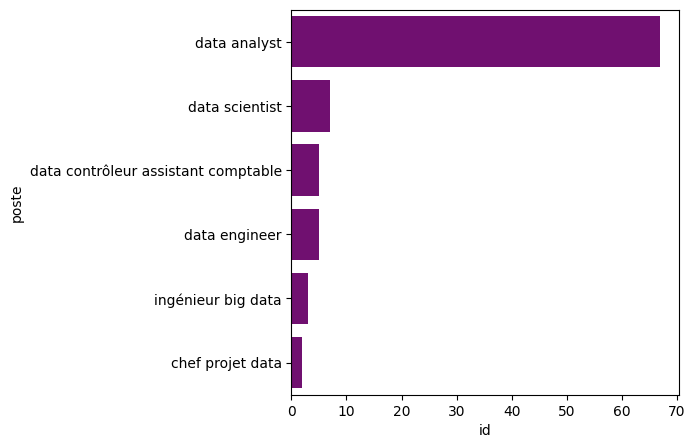

In [9]:
yr_5=resultat.groupby('poste').count().sort_values('id',ascending=False).head(6)
plt.figure(figsize=(5, 5))
print(yr_5)
sns.barplot(x='id',y='poste',data=yr_5, color='purple')

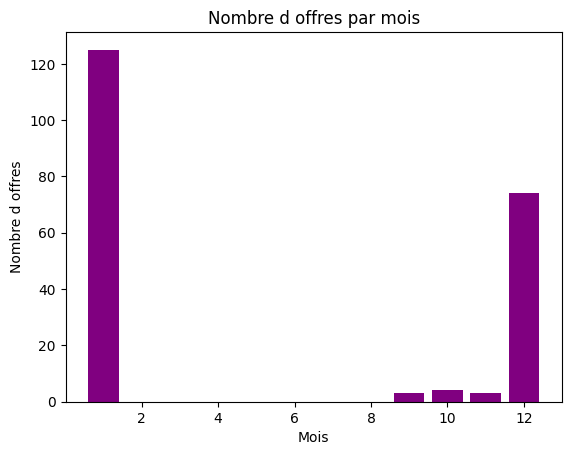

In [10]:
monthly_counts = resultat['Mois'].value_counts().sort_index()
plt.bar(monthly_counts.index, monthly_counts.values, color='purple')

plt.xlabel('Mois')
plt.ylabel('Nombre d offres')
plt.title('Nombre d offres par mois')


plt.show()

In [11]:
salaire = resultat['Salchiffre']
salaire.replace('', np.nan, inplace=True)
salaire.dropna(inplace=True)
salaire = salaire.apply(lambda x: float(x) if isinstance(x, (int, float)) else pd.to_numeric(x, errors='coerce'))
salaire.astype(float)
salaire = salaire.tolist()
salaire_moyen = np.mean(salaire)
salaire_moyen

40.34444444444444

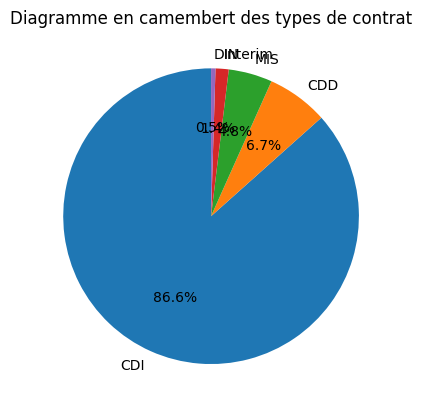

In [12]:
count_by_category = resultat['typeContrat'].value_counts()
plt.pie(count_by_category, labels=count_by_category.index, autopct='%1.1f%%', startangle=90)

plt.title('Diagramme en camembert des types de contrat')

plt.show()

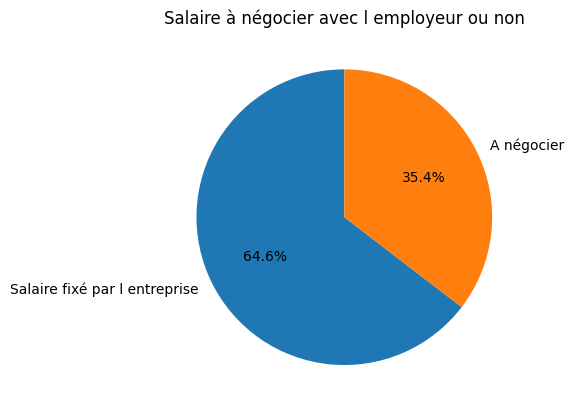

In [13]:
mask_null = resultat['Salchiffre'].isnull()

count_values = resultat['Salchiffre'].count()
count_null = mask_null.sum()


plt.pie([count_values, count_null], labels=['Salaire fixé par l entreprise', 'A négocier'], autopct='%1.1f%%', startangle=90)

plt.title('Salaire à négocier avec l employeur ou non')

plt.show()

# Analyse Corpus

Text(0, 0.5, 'Fréquence')

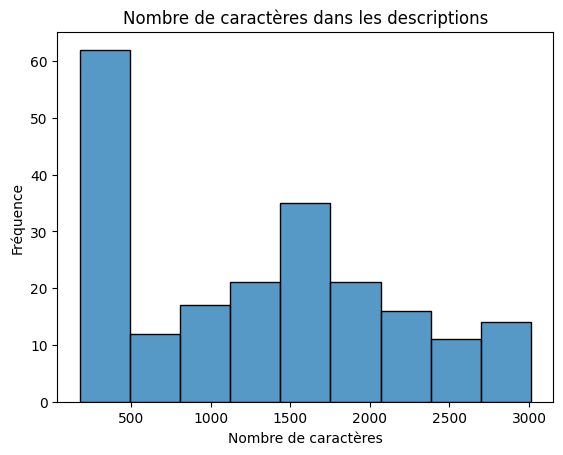

In [14]:
nb_chars = []
for index, row in resultat.iterrows():
    description=row['description']
    nb_chars.append(len(description))
sns.histplot(x=nb_chars)
plt.title('Nombre de caractères dans les descriptions')
plt.xlabel('Nombre de caractères')
plt.ylabel('Fréquence')

[['lhh', 'recruitment', 'solution', 'cabinet', 'conseil', 'recrutement', 'intérim', 'spécialisé', 'management', 'transition', 'évaluation', 'dexpertes', 'cadre', 'dirigeantes', 'recherche', 'client', 'secteur', 'luxe', 'data', 'analyst', 'supply', 'chain', 'mission', 'dintérim', 'dun', 'mois', 'minimum', 'prise', 'poste', 'urgente', 'semaine', 'janvier', 'lieu', 'paris', 'rémunération', 'annuels', 'bruts', 'type', 'contrat', 'intérim', 'dun', 'mois', 'minimum', 'sou', 'responsabilité', 'responsable', 'logistique', 'sein', 'service', 'ecommerce', 'charge', 'lanalyse', 'flux', 'entrant', 'sortants', 'mission', 'principales', 'suivi', 'partie', 'aprèsvente', 'notamment', 'nombre', 'pièces', 'retournées', 'rapport', 'nombre', 'pièces', 'remboursées', 'pointage', 'écarts', 'rapport', 'états', 'commandes', 'réalisation', 'dune', 'analyse', 'décarts', 'perte', 'vol', 'bac', 'minimum', 'moins', 'expérience', 'lanalyse', 'flux', 'entrant', 'sortants', 'laise', 'chiffres', 'rigoureux', 'maîtrise

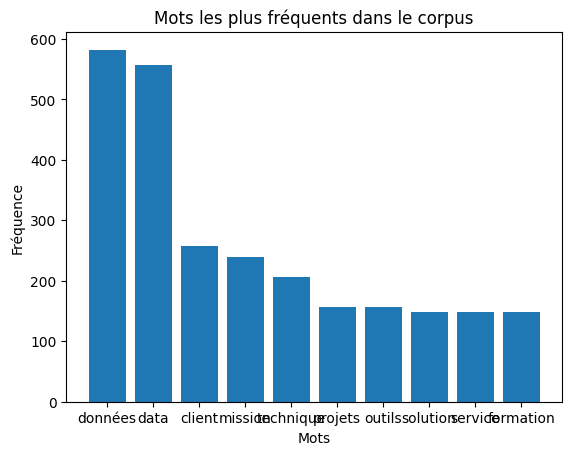

In [15]:
from collections import Counter 

cleaned_corpus= [phrase.split() for phrase in resultat['description']]
liste_resultante = []
for liste in cleaned_corpus:
    liste_resultante.extend(liste)
print(cleaned_corpus)
word_counts = Counter(liste_resultante)

# 10 mots les plus fréquents
top_words = word_counts.most_common(10)


print("Mots les plus fréquents :", top_words)


plt.bar(*zip(*top_words))
plt.xlabel('Mots')
plt.ylabel('Fréquence')
plt.title('Mots les plus fréquents dans le corpus')
plt.show()

# TF IDF 


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer, TfidfTransformer


textes = resultat['description'].astype('str').tolist()

vectorizer = TfidfVectorizer()
matrice_tfidf = vectorizer.fit_transform(textes)


mots = vectorizer.get_feature_names_out()

df_tfidf = pd.DataFrame(matrice_tfidf.toarray(), columns=mots)


print(df_tfidf)

     aaaa  abil  abonnement  abonnements  aboutir  abstraite  académie  \
0     0.0   0.0         0.0          0.0      0.0        0.0       0.0   
1     0.0   0.0         0.0          0.0      0.0        0.0       0.0   
2     0.0   0.0         0.0          0.0      0.0        0.0       0.0   
3     0.0   0.0         0.0          0.0      0.0        0.0       0.0   
4     0.0   0.0         0.0          0.0      0.0        0.0       0.0   
..    ...   ...         ...          ...      ...        ...       ...   
204   0.0   0.0         0.0          0.0      0.0        0.0       0.0   
205   0.0   0.0         0.0          0.0      0.0        0.0       0.0   
206   0.0   0.0         0.0          0.0      0.0        0.0       0.0   
207   0.0   0.0         0.0          0.0      0.0        0.0       0.0   
208   0.0   0.0         0.0          0.0      0.0        0.0       0.0   

     acceptez  accepté  access  ...  évolutive  évolutives  évolués  \
0         0.0      0.0     0.0  ...     

In [17]:
pd.set_option('display.max_columns', None)

print(df_tfidf)

pd.reset_option('display.max_columns')

     aaaa  abil  abonnement  abonnements  aboutir  abstraite  académie  \
0     0.0   0.0         0.0          0.0      0.0        0.0       0.0   
1     0.0   0.0         0.0          0.0      0.0        0.0       0.0   
2     0.0   0.0         0.0          0.0      0.0        0.0       0.0   
3     0.0   0.0         0.0          0.0      0.0        0.0       0.0   
4     0.0   0.0         0.0          0.0      0.0        0.0       0.0   
..    ...   ...         ...          ...      ...        ...       ...   
204   0.0   0.0         0.0          0.0      0.0        0.0       0.0   
205   0.0   0.0         0.0          0.0      0.0        0.0       0.0   
206   0.0   0.0         0.0          0.0      0.0        0.0       0.0   
207   0.0   0.0         0.0          0.0      0.0        0.0       0.0   
208   0.0   0.0         0.0          0.0      0.0        0.0       0.0   

     acceptez  accepté  access  accessible  accessibles  acclamées  \
0         0.0      0.0     0.0         0.

In [18]:
#reduction du tf_idf pour plus de pertinence

col = ['python', 'sql', 'machine','learning','data','analyse', 'mining', 'warehouse',
 'visualization', 'power','excel', 'savoirfaire', 'satisfaction',
'statistique', 'processing', 'nlp', 'social', 
'deep','learning','artificielle', 'spécialisée', 'spécialisé', 'soutien', 'quality', 'management', 'etl', 'software', 
'cloud','aws', 'azure', 'universitaire', 'télétravail','travail', 'tensorflow', 'support', 'suivre', 'structure', 'stratégie', 
'statistique', 'autonome', 'curiosité', 'flexible', 'adaptabilité']

In [19]:
df_tfidf = df_tfidf[col]
print(df_tfidf)

     python       sql  machine  learning      data   analyse  mining  \
0       0.0  0.000000      0.0       0.0  0.029172  0.064638     0.0   
1       0.0  0.042301      0.0       0.0  0.060656  0.000000     0.0   
2       0.0  0.000000      0.0       0.0  0.062583  0.000000     0.0   
3       0.0  0.000000      0.0       0.0  0.051470  0.000000     0.0   
4       0.0  0.000000      0.0       0.0  0.000000  0.065307     0.0   
..      ...       ...      ...       ...       ...       ...     ...   
204     0.0  0.000000      0.0       0.0  0.000000  0.000000     0.0   
205     0.0  0.000000      0.0       0.0  0.000000  0.000000     0.0   
206     0.0  0.000000      0.0       0.0  0.000000  0.000000     0.0   
207     0.0  0.000000      0.0       0.0  0.000000  0.000000     0.0   
208     0.0  0.000000      0.0       0.0  0.060005  0.132956     0.0   

     warehouse  visualization  power  ...  tensorflow  support    suivre  \
0          0.0            0.0    0.0  ...         0.0      

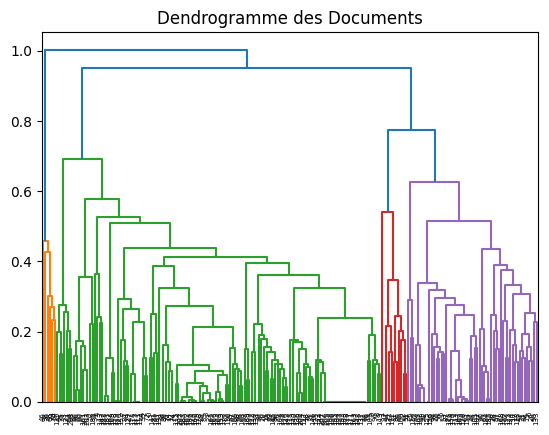

In [20]:
from scipy.cluster import hierarchy

linkage_matrix = hierarchy.linkage(df_tfidf, method='ward')
dendrogram = hierarchy.dendrogram(linkage_matrix, labels=df_tfidf.index, leaf_rotation=90)
plt.title('Dendrogramme des Documents')
plt.show()

In [21]:
from scipy.cluster.hierarchy import fcluster

distances = hierarchy.linkage(df_tfidf, method='ward')

nombre_clusters = 2

# Cluster en fonction du dendogram
clusters = fcluster(distances, t=nombre_clusters, criterion='maxclust')

df_tfidf['cluster'] = clusters
df_tfidf

,python,sql,machine,learning,data,analyse,mining,warehouse,visualization,power,...,support,suivre,structure,stratégie,statistique,autonome,curiosité,flexible,adaptabilité,cluster
0,0.0,0.000000,0.0,0.0,0.029172,0.064638,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,2
1,0.0,0.042301,0.0,0.0,0.060656,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.104125,0.000000,0.0,0.000000,0.0,0.0,2
2,0.0,0.000000,0.0,0.0,0.062583,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.088158,0.0,0.000000,0.000000,0.0,0.096896,0.0,0.0,2
3,0.0,0.000000,0.0,0.0,0.051470,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,2
4,0.0,0.000000,0.0,0.0,0.000000,0.065307,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.089377,0.0,0.000000,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,2
205,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,2
206,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,2
207,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,2


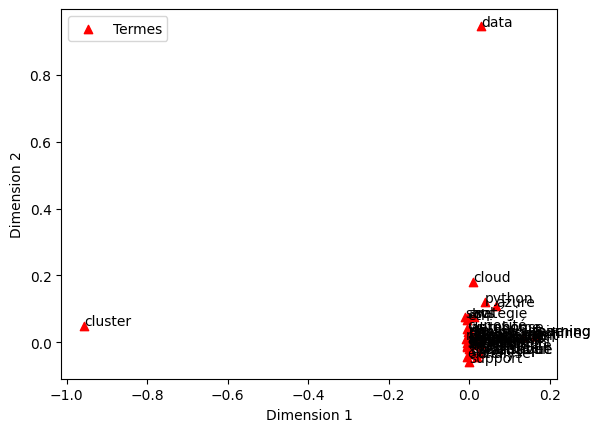

In [22]:
from sklearn.decomposition import PCA

mots = df_tfidf.columns

# ACP
n_dimensions = 2 
pca = PCA(n_components=n_dimensions)
resultats_acp = pca.fit_transform(df_tfidf)

# Coordonnées des documents 
coord_docs = pd.DataFrame(resultats_acp, columns=['Dimension 1', 'Dimension 2'])

# Coordonnées des termes 
loadings = pd.DataFrame(pca.components_.T, index=df_tfidf.columns, columns=['Dimension 1', 'Dimension 2'])

# Tremes
plt.scatter(loadings['Dimension 1'], loadings['Dimension 2'], color='red', marker='^', label='Termes')

# Annotations
for i, txt in enumerate(mots):
    plt.annotate(txt, (loadings.iloc[i, 0], loadings.iloc[i, 1]))

# Ajoutez des labels
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.legend()

plt.show()

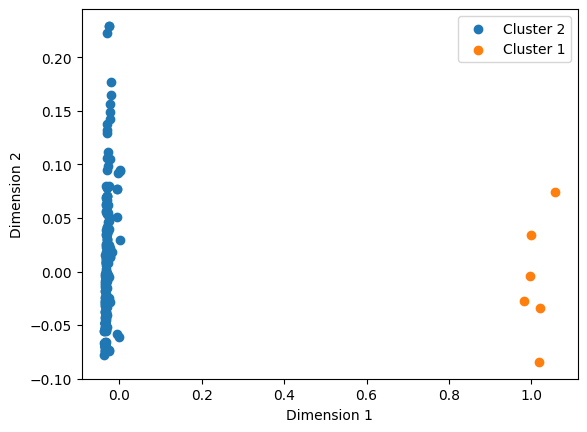

In [23]:
for cluster in df_tfidf['cluster'].unique():
    documents_cluster = df_tfidf[df_tfidf['cluster'] == cluster].index
    plt.scatter(coord_docs.loc[documents_cluster, 'Dimension 1'], coord_docs.loc[documents_cluster, 'Dimension 2'], label=f'Cluster {cluster}')

# Ajoutez des labels 
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.legend()

plt.show()

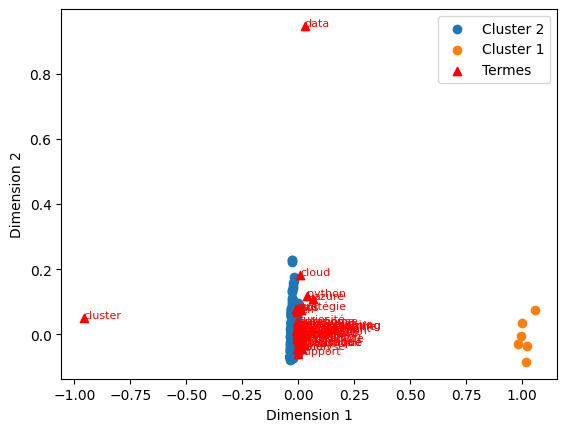

In [24]:
pca = PCA(n_components=n_dimensions)
resultats_acp = pca.fit_transform(df_tfidf)

# Coordonnées des documents
coord_docs = pd.DataFrame(resultats_acp, columns=['Dimension 1', 'Dimension 2'])

# Coordonnées des termes 
loadings = pd.DataFrame(pca.components_.T, index=mots, columns=['Dimension 1', 'Dimension 2'])

# Documents avec couleurs par cluster
for cluster in df_tfidf['cluster'].unique():
    documents_cluster = df_tfidf[df_tfidf['cluster'] == cluster].index
    plt.scatter(coord_docs.loc[documents_cluster, 'Dimension 1'], coord_docs.loc[documents_cluster, 'Dimension 2'], label=f'Cluster {cluster}')

# Termes
plt.scatter(loadings['Dimension 1'], loadings['Dimension 2'], color='red', marker='^', label='Termes')

# Annotations
for i, txt in enumerate(mots):
    plt.annotate(txt, (loadings.iloc[i, 0], loadings.iloc[i, 1]), color='red', fontsize=8)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')


plt.legend()

plt.show()